# Import all the required libraries

In [1]:
import tensorflow as tf
import joblib
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output
import gc
import wikipedia
import signal
import time

2024-12-14 10:05:41.973162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734170742.018371   44198 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734170742.043103   44198 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-14 10:05:42.145787: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Preloading the Models

In [3]:
mblnet = tf.keras.models.load_model("models/keras_mobilenetv2/ib25_mobilenetv2.keras")
vggmdl = tf.keras.models.load_model("models/keras_vgg19/ib25_vgg19.keras")
class_name = joblib.load("models/keras_vgg19/class_name.pkl")

I0000 00:00:1734170755.679401   44198 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/sidthechillguy/miniconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Viewing the Classes for which the model can predict.

In [4]:
class_name

['Asian-Green-Bee-Eater',
 'Brown-Headed-Barbet',
 'Cattle-Egret',
 'Common-Kingfisher',
 'Common-Myna',
 'Common-Rosefinch',
 'Common-Tailorbird',
 'Coppersmith-Barbet',
 'Forest-Wagtail',
 'Gray-Wagtail',
 'Hoopoe',
 'House-Crow',
 'Indian-Grey-Hornbill',
 'Indian-Peacock',
 'Indian-Pitta',
 'Indian-Roller',
 'Jungle-Babbler',
 'Northern-Lapwing',
 'Red-Wattled-Lapwing',
 'Ruddy-Shelduck',
 'Rufous-Treepie',
 'Sarus-Crane',
 'White-Breasted-Kingfisher',
 'White-Breasted-Waterhen',
 'White-Wagtail']

# Creating the Model Prediction loading Function

In [5]:
def PredictFunction(inimg):

    global mblnet
    global vggmdl
    
    tf.keras.backend.clear_session()
    gc.collect
    
    img = tf.keras.preprocessing.image.img_to_array(inimg)
    img = np.expand_dims(img, axis=0)

    predmbnet = mblnet.predict(img)
    predvgg = vggmdl.predict(img)

    predclassmbnet = np.argmax(predmbnet[0])
    predclassvgg = np.argmax(predvgg[0])

    confmbnet = predmbnet[0][predclassmbnet]
    confvgg = predvgg[0][predclassvgg]
    
    if (predclassmbnet == predclassvgg):
        return class_name[predclassvgg], "VGG19 and MobileNetV2",(confmbnet + confvgg)/2
    else:
        if(confvgg>confmbnet):
            return class_name[predclassvgg], "VGG19", confvgg
        else:
            return class_name[predclassmbnet], "MobileNetV2", confmbnet

# Add a warmup run so the models are initlialised before they start prediction

In [12]:
# warm up
def warmstart():
    img = Image.open("test_images/CmmnTilrbrd.jpeg")
    name, modelused, conf = PredictFunction(img)
    print(name,"*|*",modelused,"*|*",conf)

In [13]:
warmstart()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
Common-Tailorbird *|* VGG19 and MobileNetV2 *|* 0.9992428


# Create the Signal Timeout error handling class

Given our models on average take less than a second to predict a single image, we shall allow the model to take a miximum of 6 seconds to predict.

In [8]:
# Define a custom exception for timeout
class TimeoutException(Exception):
    pass

# Define a handler for the timeout
def timeout_handler(signum, frame):
    raise TimeoutException


# Set the signal handler for the alarm signal
signal.signal(signal.SIGALRM, timeout_handler)

# Function to run with a timeout
def run_with_timeout(inimg, timeout):
    signal.alarm(timeout)  # Set the alarm
    try:
        a, b, c = PredictFunction(inimg)
        return a, b, c

    except TimeoutException:
        print("Function took too long to complete.")
    finally:
        signal.alarm(0)  # Disable the alarm

In [9]:
maxrun = 0 # the function will reload a maximum of 2 times. Any more than that and the function will abort prediction.
while True:

    try:
        img = Image.open("test_images/indp.jpg")
        name, modelused, conf = run_with_timeout(img, 6) # 6 second maximum runtime. note, please adjustt this value based on your device.
        break
    
    except:
        del mblnet
        del vggmdl
        del tf
        
        import tensorflow as tf
        gpus = tf.config.experimental.list_physical_devices('GPU')
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        mblnet = tf.keras.models.load_model("models/keras_mobilenetv2/ib25_mobilenetv2.keras")
        vggmdl = tf.keras.models.load_model("models/keras_vgg19/ib25_vgg19.keras")
        warmstart()
        maxrun+=1
        
        if maxrun>1:
            print("Maximum Retries passed, prediction failed. Aborting.")
            break

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step


# Prediction and Wikipedia Integration

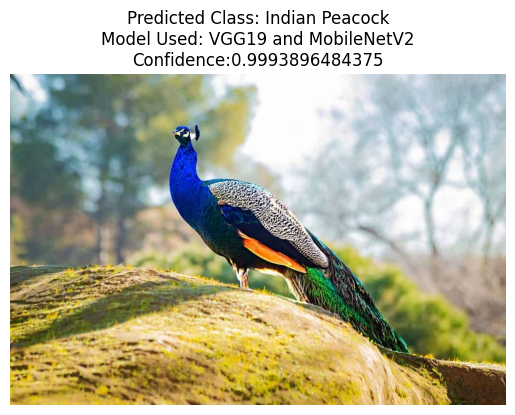

The Indian peafowl (Pavo cristatus), also known as the common peafowl or blue peafowl, is a peafowl species native to the Indian subcontinent. While it originated in the Indian subcontinent, it has since been introduced to many other parts of the world. Male peafowl are referred to as peacocks, and female peafowl are referred to as peahens, although both sexes are often referred to colloquially as a "peacock".
The Indian peafowl displays a marked form of sexual dimorphism. The brightly coloured male has a blue coloured head with a fan-shaped crest and is best known for their long train. The train is made up of elongated upper-tail covert feathers with colourful eyespots. These stiff feathers are raised into a fan and quivered in a display during courtship. The peahen is predominantly brown in colour, with a white face and iridescent green lower neck, and lack the elaborate train. There are several colour mutations of the Indian peafowl including the leucistic white peafowl.
Despite the

In [11]:
if name and modelused and conf:
    plt.title(f"Predicted Class: {name}\nModel Used: {modelused}\nConfidence:{conf}")
    plt.axis("off")
    plt.imshow(img)
    plt.show()
    
    time.sleep(3)
    
    name = name.replace("-"," ")
    search = f"{name} (bird)"
    print(wikipedia.summary(search))
    
    clear_output(wait=True)